# Machine Learning Engineer Nanodegree

## Capstone Report
Rodrigo Moreira Fagundes
December 23rd, 2018

## Introduction

In such a large developing country as Brazil, with so many different economic and cultural setups, tackling modern slavery efficiently is a huge challenge. According the Observatório Digital do Trabalho Escravo (https://observatorioescravo.mpt.mp.br/), from 2003 to 2018, 44,229 people were rescued from degrading working conditions in 3,318 inspections (13.33 rescues per inspaction). 2,006 successful diligences took place in 766 of the 5,570 brazilian municipalities (a coverage of 13.75%). If we add the 1,847 inspections with no rescues, the coverage raises to a 37.9%, with 2,112 locations, but it reveals a success rate of 52.06%. Since 2015, the number of diligences have benn falling, returning to the yearly inspections frequency seen in 2003-2007.

Some regions are not accessible, taking too long to mobilize an inspection - allowing perpetrators to move their operations or just hide their illegal aspects during the audit. Traditionally, the inspections are mobilized based on a denounce and evidences that support it. The most vulnerable people, though, lack the opportunity to reach government agencies.

In opposition, urban centers with high population density have a large number of enterprises to be verified, rendering a traditional coverage goal unrealistic - both due to cost and manpower. Modern slavery practices in urban centers tend to be disguised as just poor labor standards or practices, facing long disputes before estabilishing the perpetration.

### Problem Statement

Given the scenarios, government agencies have to craft a way to concentrate its resources in targets that reach more vulnerable people. One way to create such a prioritization can be trying to identify, using classification, the locations that would most likely to result in more rescues per diligence. Some inputs are very promising for that task, such as municipalities profiles - based on census data provided by IBGE (Instituto Nacional de Geografia e Estatística) - and the record of previous inspections - from MTE (Ministério do Trabalho e Emprego). The output of the classification will indicate municipalities in which inspections may result in maximum rescue rates.

### Datasets and Inputs

For this study, we're using three datasets. The first is a collection of information on municipality's census, collected by IBGE (Instituto Nacional de Geografia e Estatística), available to the public. The comprehensive dataset, with no relevant missing data so far, is a suitable source for identifying profiles and similarities between locations. Is is also a reliable dataset, once the census conducted by IBGE goes through a rigorous methodology.

The second and third datasets will be the disidentificated registers of operations and inspections. They contain information on the municipalities where inspections took place, how many people were rescued from degrading work conditions, their origin and where they claimed to reside at the moment. In the current study, they'll be used as a base for risk rating, which in turn will become the label for classification.

### Solution Statement

One solution to the problem can be resource optimization by defining high priorities munuicipalities based on statistical inference. By using municipalities similarities and previous diligences data, it's reasonable to focus on locations that are most likely to result in a more effective action, rescuing more people in a single inspection, for instance. By prioritizing municipalities according to the distribution of rescues per inspection, the model can be repeated, hopefully with decreasing numbers of perpetrations.

## Exploring the datasets

### Census

The census data, collected by IBGE (https://www.ibge.gov.br/) was provided by Smartlab (http://smartlab.mpt.mp.br) in December 22nd, 2018 as a CSV file. The dataset is the same used in the Observatório Digital do Trabalho Escravo (http://observatorioescravo.mpt.mp.br). It contains 73 indicators, including GDP, employed population by age, among others. We took the more comprehensive data, from 2010.

In order to remove municipalities' identification, we appended the average of rescues per inspections from the rescues data to the census dataset. The input was generated by MTE (http://mte.gov.br) and provided by Smartlab. It is also used in the Observatório Digital do Trabalho Escravo.


In [1]:
import pandas as pd

# Reading the CSV
df = pd.read_csv('data/dataset.csv')

# Formating data from vl_indicador
import re
df['vl_no_format'] = df['vl_indicador'].map(lambda x: float(re.sub('[\.]', '', str(x))))

# Pivoting the data
df = df.pivot_table(index='cd_mun_ibge', columns='ds_indicador_curto', values='vl_no_format').reset_index().drop(columns=['cd_mun_ibge'])

# Exploring the data
print(df.shape)
df.head()

(5565, 113)


ds_indicador_curto,Alfabetização das pessoas de 15 anos ou mais,Analfabetismo das pessoas de 15 a 24 anos,Aprendizes em relação à população ocupada,Area Territorial,"Bolsa Família, PETI ou outros programas sociais - Domicílios que recebem",Crescimento da população de 2000 a 2010,Crianças Ocupadas,"Crianças e Adolescentes ocupados como trabalhadores domésticos, sobre o total da população de 10 a 17 anos",Crianças e Adolescentes ocupados no trabalho doméstico,Crianças e adolescentes ocupados,...,Trabalhadores por conta própria contribuintes de 16 a 64 anos,Trabalho doméstico no total de ocupados de 10 a 17 anos,Valor Adicionado Bruto,Valor Adicionado Bruto a preços correntes,Valor Adicionado Bruto a preços correntes - Participação,Valor Adicionado Bruto a preços correntes - Participação Total,Valor Adicionado Bruto a preços correntes - Total,"Valor Adicionado Bruto, a preços correntes, dos serviços, da Administração",Índice de GINI do rendimento do trabalho principal - Pessoas de 16 a 64 anos ocupadas com rendimento,Índice de GINI do rendimento domiciliar dos domicílios particulares
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,420.0,NaN,...,NaN,NaN,NaN,NaN,7.047750e+13,NaN,NaN,NaN,NaN,NaN
1,6.544000e+15,NaN,NaN,NaN,142882.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.681699e+13,NaN,NaN,NaN,NaN,473.0
2,4.573000e+03,NaN,NaN,NaN,5066.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7028754.0,NaN,NaN,NaN,NaN,89750.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,92.0,1096192.0,NaN,NaN,NaN,NaN,335910.0,NaN,NaN
4,NaN,NaN,NaN,NaN,6049.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The census data provided don't seem to be as thorough as expected. It should be revisited in the future studies, should the density proves too low to provide a strong profile for the municipality.

In [2]:
# Checking sparsity/density
sdf = df.to_sparse()
print(sdf.density)

0.1546629137545818


Since the dataset revealed itself too sparse, we'll conduct the study using just the rescues dataset. It contains a high dimensionality (higher than the census), because of the depth and granularity of some dimensions.

### Rescue data

The inspection data was colected from the Observatório Digital do Trabalho Escravo (http://observatorioescravo.mpt.mp.br) in December 22nd, 2018 as a CSV file. It contains register from rescues with high dimensionality, since the indicators were built taking into account the munber of responses of each rescuee survey and includes info on gender, race, instruction, age, occupation (current and desired), among others.

All data are numeric indicatiors, with the ammount of people. They can be divided into 3 main segments:

* '\_rgt\_' marks the data from rescues or rescuees;
* '\_res\_' reveals information about the people that reside in that place and were rescued anywhere
* '\_nat\_' means the amount of people born in a municipality, regardless of where they were rescued

Another important variable is _ds_agregacao_primaria_, which is a second level of granularity, an specialization of the indicator.

__For example:__ _te_res_raca_ with ds_agregacao_primaria 'Branca' in the municipality 0000000 is an indicator that counts the number of white people that resided in the city 0000000, regardless of where they were rescued.

In [3]:
# Reading the CSV
df = pd.read_csv('data/dataset_resgates.csv')

# Setting a default level to summarized indicators
df['ds_agreg_primaria'] = df['ds_agreg_primaria'].fillna('default')

# Pivoting the data
# Since the data come from surveys, the absence of information means no occurence of that instance, thus the zero-filling.
df = df.pivot_table(
    index='cd_mun_ibge',
    columns=['cd_indicador','ds_agreg_primaria'],
    values='vl_indicador',
    fill_value=0
).reset_index().drop(columns=['cd_mun_ibge'])

# Exploring the data
print(df.shape)

sdf = df.to_sparse()
print(sdf.density)

df.head()

/Users/rmfagundes/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(3371, 1518)
1.0


cd_indicador      te_insp_rgt te_inspecoes  te_nat  \
ds_agreg_primaria     default      default default   
0                           0            0       1   
1                           0            1       1   
2                           0            0       3   
3                           0            0       3   
4                           0            0       3   

cd_indicador                                          te_nat_cnae  \
ds_agreg_primaria Abate de suínos, aves e outros pequenos animais   
0                                                               0   
1                                                               0   
2                                                               0   
3                                                               0   
4                                                               0   

cd_indicador                                      \
ds_agreg_primaria Administração pública em geral   
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

cd_indicador                                                                          \
ds_agreg_primaria Aluguel de máquinas e equipamentos não especificados anteriormente   
0                                                                  0                   
1                                                                  0                   
2                                                                  0                   
3                                                                  0                   
4                                                                  0                   

cd_indicador                                                             \
ds_agreg_primaria Aparelhamento e outros trabalhos em pedras Apicultura   
0                                                          0          0   
1                                                          0          0   
2                                                          0          0   
3                                                          0          0   
4                                                          0          0   

cd_indicador                     \
ds_agreg_primaria Armazenamento   
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

cd_indicador                                                                                              \
ds_agreg_primaria Atividade Medica Ambulatorial com Recursos para Realizacao de Procedimentos Cirurgicos   
0                                                                  0                                       
1                                                                  0                                       
2                                                                  0                                       
3                                                                  0                                       
4                                                                  0                                       

cd_indicador            ...        \
ds_agreg_primaria       ...         
0                       ...         
1                       ...         
2                       ...         
3                       ...         
4                       ...         

cd_indicador                                                                                    te_res_raca  \
ds_agreg_primaria Pessoa Que Se Enquadrar Como de Raça Amarela ( de Origem Japonesa, Chinesa, Coreana, Etc)   
0                                                                  0                                          
1                                

## Data Preparation

First of all, municipalities with no rescue will be removed from the dataset. As proposed, only those with actual rescue will be subject of the current study.

In [4]:
# Removing rows with te_rgt = 0
df = df[df.te_rgt.default != 0]

print(df.shape)

sdf = df.to_sparse()
print(sdf.density)

df.head()

(753, 1518)
1.0


cd_indicador      te_insp_rgt te_inspecoes  te_nat  \
ds_agreg_primaria     default      default default   
6                          10           16      27   
11                          3            3       6   
20                          1            1       2   
22                          2            2       2   
24                          1            1       0   

cd_indicador                                          te_nat_cnae  \
ds_agreg_primaria Abate de suínos, aves e outros pequenos animais   
6                                                               0   
11                                                              0   
20                                                              0   
22                                                              0   
24                                                              0   

cd_indicador                                      \
ds_agreg_primaria Administração pública em geral   
6                                              0   
11                                             0   
20                                             0   
22                                             0   
24                                             0   

cd_indicador                                                                          \
ds_agreg_primaria Aluguel de máquinas e equipamentos não especificados anteriormente   
6                                                                  0                   
11                                                                 0                   
20                                                                 0                   
22                                                                 0                   
24                                                                 0                   

cd_indicador                                                             \
ds_agreg_primaria Aparelhamento e outros trabalhos em pedras Apicultura   
6                                                          0          0   
11                                                         0          0   
20                                                         0          0   
22                                                         0          0   
24                                                         0          0   

cd_indicador                     \
ds_agreg_primaria Armazenamento   
6                             0   
11                            0   
20                            0   
22                            0   
24                            0   

cd_indicador                                                                                              \
ds_agreg_primaria Atividade Medica Ambulatorial com Recursos para Realizacao de Procedimentos Cirurgicos   
6                                                                  0                                       
11                                                                 0                                       
20                                                                 0                                       
22                                                                 0                                       
24                                                                 0                                       

cd_indicador            ...        \
ds_agreg_primaria       ...         
6                       ...         
11                      ...         
20                      ...         
22                      ...         
24                      ...         

cd_indicador                                                                                    te_res_raca  \
ds_agreg_primaria Pessoa Que Se Enquadrar Como de Raça Amarela ( de Origem Japonesa, Chinesa, Coreana, Etc)   
6                                                                  2                                          
11                               

The dataset has a high dimensionality. In order to perform the model, we need to rationalize it. Before the transformation to CSV, we categorized the age of recuees from numeric bins to 'minor' and 'adult' - this is important to differentiate child labor and slavery of adults.

We'll also remove occupational data. Its granularity is too high, leading to a right-tailed distribution, concentrated near the origin.

In [5]:
idx = pd.IndexSlice

occupation = df.loc[idx[:], idx['te_nat_cnae', :]]
occupation_sample = occupation.head(10)
occupation_sample = occupation_sample.loc[:, (occupation_sample != 0).any(axis=0)]

pd.plotting.scatter_matrix(occupation_sample, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
occupation_sample.head(10)

cd_indicador                                   te_nat_cnae  \
ds_agreg_primaria Atividades de Apoio a Producao Florestal   
6                                                        0   
11                                                       0   
20                                                       0   
22                                                       0   
24                                                       0   
26                                                       0   
34                                                       1   
36                                                       0   
41                                                       0   
44                                                       0   

cd_indicador                                                                                        \
ds_agreg_primaria Comércio varejista de produtos de padaria, laticínio, doces, balas e semelhantes   
6                                                                  0                                 
11                                                                 0                                 
20                                                                 1                                 
22                                                                 0                                 
24                                                                 0                                 
26                                                                 0                                 
34                                                                 0                                 
36                                                                 0                                 
41                                                                 0                                 
44                                                                 0                                 

cd_indicador                                          \
ds_agreg_primaria Construcao de Rodovias e Ferrovias   
6                                                  0   
11                                                 0   
20                                                 0   
22                                                 0   
24                                                 0   
26                                                 0   
34                                                 0   
36                                                 0   
41                                                 1   
44                                                 0   

cd_indicador                                                      \
ds_agreg_primaria Criacao de Bovinos para Corte Cultivo de Arroz   
6                                            13                4   
11                                            0                1   
20                                            1                0   
22                                            1                0   
24                                            0                0   
26                                           18                2   
34                                            0                1   
36                                            1                1   
41                                            0                0   
44                                            5                3   

cd_indicador                                                     \
ds_agreg_primaria Desdobramento de madeira Fabricacao de Alcool   
6                                        0                    0   
11                                       0                    0   
20                                       0                    0   
22                                       0                    0   
24                                       0                    0   
26                                       0                    0   
34  

Occupations data is relevant in the context of tackling modern slavery. These data can be confronted with the joined information from CAGED (Cadastro Geral de Empregados e Desempregados) and census data, so that people can be receive instruction for jobs that are actually in demand or can be moved to loactions where there are job openings for the rescuee's desired occupation.

To the current study, though, they don't contributeto the outcome (high granularity and near-zero right-tailed distribution). Therefore, all occupations data will be removed.

In [6]:
occup_cols = [col for col in df.axes[1].get_level_values(0) if any([True for part in ['cnae','ocup'] if part in col])]
occup_cols_no_rep = list(set(occup_cols))

# Columns to be removed
print(occup_cols_no_rep)

# Dropping occupation columns
df_no_occup = df.drop(occup_cols_no_rep, axis=1, level=0)
print(df_no_occup.shape)
df_no_occup.head()

['te_res_ocup_pret', 'te_nat_cnae', 'te_res_cnae', 'te_nat_instrucao_ocup_pret', 'te_res_ocup_atual', 'te_nat_sexo_cnae', 'te_nat_ocup_atual', 'te_nat_ocup_pret']
(753, 69)


cd_indicador      te_insp_rgt te_inspecoes  te_nat te_nat_idade                \
ds_agreg_primaria     default      default default        adult default minor   
6                          10           16      27           22       0     5   
11                          3            3       6            6       0     0   
20                          1            1       2            2       0     0   
22                          2            2       2            2       0     0   
24                          1            1       0            0       0     0   

cd_indicador      te_nat_instrucao                                            \
ds_agreg_primaria  5º Ano Completo 6º ao 9º Ano Incompl >Ignorado Analfabeto   
6                                0                    3         0         11   
11                               0                    1         0          1   
20                               0                    0         0          0   
22                               0                    0         0          0   
24                               0                    0         0          0   

cd_indicador            ...        \
ds_agreg_primaria       ...         
6                       ...         
11                      ...         
20                      ...         
22                      ...         
24                      ...         

cd_indicador                                                                                    te_res_raca  \
ds_agreg_primaria Pessoa Que Se Enquadrar Como de Raça Amarela ( de Origem Japonesa, Chinesa, Coreana, Etc)   
6                                                                  2                                          
11                                                                 0                                          
20                                                                 0                                          
22                                                                 5                                          
24                                                                 0                                          

cd_indicador      te_res_raca_idade                                      \
ds_agreg_primaria    >Não Informado Pessoa Que Se Enquadrar Como Branca   
6                                 0                                   0   
11                                0                                   0   
20                                0                                   0   
22                                0                                   0   
24                                0                                   0   

cd_indicador                                                                                                                                                    \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Parda ou Se Declarar Como Mulata, Cabocla, Cafuza, Mameluca ou Mestiça de Preto com Pessoa de Outra Cor ou Raça   
6                                                                  0                                                                                             
11                                                                 0                                                                                             
20                                                                 0                                                                                             
22                                                                 0                                                                                             
24                                                                 0                                                                                             

cd_indicador                                          \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Preta   
6                                                  0   
11  

After dropping the occupations data, 60 features remained in the dataset.

From that collection, some actually have a secondary aggregation feature, not present in the CSV. Those will be removed.

In [7]:
# Getting the remaining indicators' codes
print(df_no_occup.axes[1].get_level_values(0))

# Indicators known (business logic) to have a secondary level
cols_sec_level = ['te_nat_instrucao_idade', 'te_nat_raca_idade', 'te_res_instrucao_idade', 'te_res_raca_idade']
df_final = df_no_occup.drop(cols_sec_level, axis=1, level=0)

print(df_final.shape)

# Checking sparsity/density
sdf = df.to_sparse()
print(sdf.density)

df_final.head()

Index(['te_insp_rgt', 'te_inspecoes', 'te_nat', 'te_nat_idade', 'te_nat_idade',
       'te_nat_idade', 'te_nat_instrucao', 'te_nat_instrucao',
       'te_nat_instrucao', 'te_nat_instrucao', 'te_nat_instrucao',
       'te_nat_instrucao', 'te_nat_instrucao', 'te_nat_instrucao',
       'te_nat_instrucao', 'te_nat_instrucao', 'te_nat_instrucao',
       'te_nat_instrucao_idade', 'te_nat_instrucao_idade',
       'te_nat_instrucao_idade', 'te_nat_instrucao_idade', 'te_nat_raca',
       'te_nat_raca', 'te_nat_raca', 'te_nat_raca', 'te_nat_raca',
       'te_nat_raca', 'te_nat_raca_idade', 'te_nat_raca_idade',
       'te_nat_raca_idade', 'te_nat_raca_idade', 'te_nat_raca_idade',
       'te_nat_sexo', 'te_nat_sexo', 'te_ope', 'te_res', 'te_res_idade',
       'te_res_idade', 'te_res_idade', 'te_res_instrucao', 'te_res_instrucao',
       'te_res_instrucao', 'te_res_instrucao', 'te_res_instrucao',
       'te_res_instrucao', 'te_res_instrucao', 'te_res_instrucao',
       'te_res_instrucao', 'te_res_i

cd_indicador      te_insp_rgt te_inspecoes  te_nat te_nat_idade                \
ds_agreg_primaria     default      default default        adult default minor   
6                          10           16      27           22       0     5   
11                          3            3       6            6       0     0   
20                          1            1       2            2       0     0   
22                          2            2       2            2       0     0   
24                          1            1       0            0       0     0   

cd_indicador      te_nat_instrucao                                            \
ds_agreg_primaria  5º Ano Completo 6º ao 9º Ano Incompl >Ignorado Analfabeto   
6                                0                    3         0         11   
11                               0                    1         0          1   
20                               0                    0         0          0   
22                               0                    0         0          0   
24                               0                    0         0          0   

cd_indicador            ...          te_res_raca  \
ds_agreg_primaria       ...       >Não Informado   
6                       ...                   63   
11                      ...                    4   
20                      ...                    1   
22                      ...                    1   
24                      ...                    0   

cd_indicador                                           \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Branca   
6                                                   1   
11                                                  0   
20                                                  0   
22                                                  2   
24                                                  0   

cd_indicador                                                      \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Indígena ou Índia   
6                                                              0   
11                                                             0   
20                                                             0   
22                                                             0   
24                                                             0   

cd_indicador                                                                                                                                                    \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Parda ou Se Declarar Como Mulata, Cabocla, Cafuza, Mameluca ou Mestiça de Preto com Pessoa de Outra Cor ou Raça   
6                                                                 10                                                                                             
11                                                                 0                                                                                             
20                                                                 0                                                                                             
22                                                                 6                                                                                             
24                                                                 0                                                                                             

cd_indicador                                          \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Preta   
6                                                  1   
11                                                 1   
20                                                 0   
22                                                 2   
24                                                 0   

cd_indicador                                                                                         

The final dataset has 51 features. 

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
feats = df_final.axes[1].get_level_values(0)[:-1]

df_final = pd.DataFrame(data = df_final)
df_final.loc[idx[:], idx[feats,:]] = scaler.fit_transform(df_final.loc[idx[:], idx[feats,:]])

df_final.head()

/Users/rmfagundes/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


cd_indicador      te_insp_rgt te_inspecoes    te_nat te_nat_idade          \
ds_agreg_primaria     default      default   default        adult default   
6                    0.120000     0.142857  0.056250     0.046025     0.0   
11                   0.026667     0.019048  0.012500     0.012552     0.0   
20                   0.000000     0.000000  0.004167     0.004184     0.0   
22                   0.013333     0.009524  0.004167     0.004184     0.0   
24                   0.000000     0.000000  0.000000     0.000000     0.0   

cd_indicador                te_nat_instrucao                                 \
ds_agreg_primaria     minor  5º Ano Completo 6º ao 9º Ano Incompl >Ignorado   
6                  0.357143              0.0             0.061224       0.0   
11                 0.000000              0.0             0.020408       0.0   
20                 0.000000              0.0             0.000000       0.0   
22                 0.000000              0.0             0.000000       0.0   
24                 0.000000              0.0             0.000000       0.0   

cd_indicador                       ...          te_res_raca  \
ds_agreg_primaria Analfabeto       ...       >Não Informado   
6                   0.026442       ...             0.166227   
11                  0.002404       ...             0.010554   
20                  0.000000       ...             0.002639   
22                  0.000000       ...             0.002639   
24                  0.000000       ...             0.000000   

cd_indicador                                           \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Branca   
6                                            0.014085   
11                                           0.000000   
20                                           0.000000   
22                                           0.028169   
24                                           0.000000   

cd_indicador                                                      \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Indígena ou Índia   
6                                                            0.0   
11                                                           0.0   
20                                                           0.0   
22                                                           0.0   
24                                                           0.0   

cd_indicador                                                                                                                                                    \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Parda ou Se Declarar Como Mulata, Cabocla, Cafuza, Mameluca ou Mestiça de Preto com Pessoa de Outra Cor ou Raça   
6                                                           0.089286                                                                                             
11                                                          0.000000                                                                                             
20                                                          0.000000                                                                                             
22                                                          0.053571                                                                                             
24                                                          0.000000                                                                                             

cd_indicador                                          \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Preta   
6                                           0.023810   
11                                          0.023810   
20                                          0.000000   
22                                          0.047619   
24                                          0.000000   

cd_indicador                                               

### Setting the labeling class

As proposed, the labeling class will be based on the rescues per inspection (te_rgt_per_insp). The labels (LOW, MEDIUM and HIGH) will be based on the terciles of its distribution.

/Users/rmfagundes/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    753.000000
mean      43.193323
std       72.725993
min        0.250000
25%        8.000000
50%       18.000000
75%       45.000000
max      836.500000
Name: default, dtype: float64

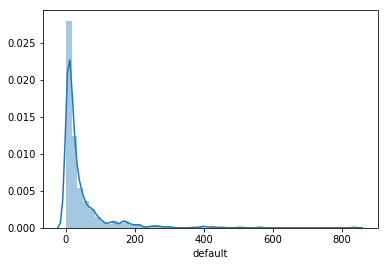

In [9]:
import seaborn as sns
sns.distplot(df_final.te_rgt_per_insp.default)

df_final.te_rgt_per_insp.default.describe()

As the distribution shows, there's a concentration of rescues per inspection near the origin. It could mean few occurences of modern slavery, if there weren't municipalities that presented much higher rates - leading to a long tail in the distribution. Perfecting resources placement could lower inspections with near-zero rescues and bring the distribution to a normal display. At the same time, incresing effectiveness in enforcement may reduce the cases with the highest rates.

In [10]:
# Categorization of the label feature
df_with_labels = df_final
df_with_labels.loc[idx[:], idx['te_rgt_per_insp',:]] = pd.qcut(
    df_final.te_rgt_per_insp.default,
    3,
    labels=["LOW", "MEDIUM", "HIGH"]
)

print(df_with_labels.te_rgt_per_insp.default.describe())

print('LOW MAX: ' + str(
    df_with_labels.loc[df_with_labels.te_rgt_per_insp.default == 'LOW', idx['te_rgt',:]].values.max())
)
print('MEDIUM MAX: ' + str(
    df_with_labels.loc[df_with_labels.te_rgt_per_insp.default == 'MEDIUM', idx['te_rgt',:]].values.max())
)

df_with_labels.head()

count     753
unique      3
top       LOW
freq      255
Name: default, dtype: object
LOW MAX: 0.04525862068965517
MEDIUM MAX: 0.13864942528735633


cd_indicador      te_insp_rgt te_inspecoes    te_nat te_nat_idade          \
ds_agreg_primaria     default      default   default        adult default   
6                    0.120000     0.142857  0.056250     0.046025     0.0   
11                   0.026667     0.019048  0.012500     0.012552     0.0   
20                   0.000000     0.000000  0.004167     0.004184     0.0   
22                   0.013333     0.009524  0.004167     0.004184     0.0   
24                   0.000000     0.000000  0.000000     0.000000     0.0   

cd_indicador                te_nat_instrucao                                 \
ds_agreg_primaria     minor  5º Ano Completo 6º ao 9º Ano Incompl >Ignorado   
6                  0.357143              0.0             0.061224       0.0   
11                 0.000000              0.0             0.020408       0.0   
20                 0.000000              0.0             0.000000       0.0   
22                 0.000000              0.0             0.000000       0.0   
24                 0.000000              0.0             0.000000       0.0   

cd_indicador                       ...          te_res_raca  \
ds_agreg_primaria Analfabeto       ...       >Não Informado   
6                   0.026442       ...             0.166227   
11                  0.002404       ...             0.010554   
20                  0.000000       ...             0.002639   
22                  0.000000       ...             0.002639   
24                  0.000000       ...             0.000000   

cd_indicador                                           \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Branca   
6                                            0.014085   
11                                           0.000000   
20                                           0.000000   
22                                           0.028169   
24                                           0.000000   

cd_indicador                                                      \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Indígena ou Índia   
6                                                            0.0   
11                                                           0.0   
20                                                           0.0   
22                                                           0.0   
24                                                           0.0   

cd_indicador                                                                                                                                                    \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Parda ou Se Declarar Como Mulata, Cabocla, Cafuza, Mameluca ou Mestiça de Preto com Pessoa de Outra Cor ou Raça   
6                                                           0.089286                                                                                             
11                                                          0.000000                                                                                             
20                                                          0.000000                                                                                             
22                                                          0.053571                                                                                             
24                                                          0.000000                                                                                             

cd_indicador                                          \
ds_agreg_primaria Pessoa Que Se Enquadrar Como Preta   
6                                           0.023810   
11                                          0.023810   
20                                          0.000000   
22                                          0.047619   
24                                          0.000000   

cd_indicador                                               

## Classification - Random Forest

### Splitting the dataset

In [11]:
from sklearn.model_selection import train_test_split

rs = 64

# Split the features and labeling class in train, validate and test
feats = df_final.axes[1].get_level_values(0)[:-1]
labels = df_final.axes[1].get_level_values(0)[-1]

feats_subset = df_final.loc[idx[:], idx[feats,:]]
labels_subset = df_final.loc[idx[:], idx[labels,:]]

# Splitting in half for training/validation and testing
X_trainvalidate, X_test, y_trainvalidate, y_test = train_test_split(
    feats_subset, labels_subset, test_size = 0.5, random_state = rs
)

# Splitting the train/validate into training and validating subsets
X_train, X_validate, y_train, y_validate = train_test_split(
    X_trainvalidate, y_trainvalidate, test_size = 0.2, random_state = rs
)

print(X_train.shape)
print(y_train.shape)
print(X_validate.shape)
print(y_validate.shape)
print(X_test.shape)
print(y_test.shape)

(300, 50)
(300, 1)
(76, 50)
(76, 1)
(377, 50)
(377, 1)


### Training the model

Accuracy: 0.7833333333333333
F Score (each label): [0.78833693 0.83333333 0.73608618]
F Score: 0.7833333333333333


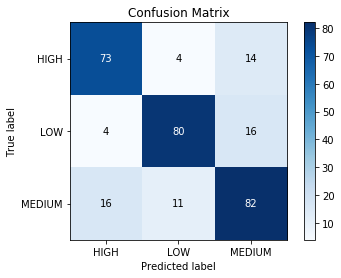

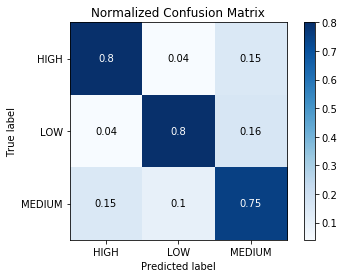

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

classifier = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=rs)
learner = classifier.fit(X_train, y_train.values.ravel())
predictions_train = cross_val_predict(learner, X_train, y_train.values.ravel(), cv=10)

# Metrics
from sklearn.metrics import fbeta_score, accuracy_score

print('Accuracy: ' + str(accuracy_score(y_train, predictions_train)))
print('F Score (each label): ' + str(fbeta_score(y_train, predictions_train, beta = 0.5, average=None)))
print('F Score: ' + str(fbeta_score(y_train, predictions_train, beta = 0.5, average='micro')))

# Confusion matrix
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_train, predictions_train, normalize=False)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, normalize=True)
plt.show()

### Validating the model

Accuracy: 0.7631578947368421
F Score (each label): [0.7751938  0.76612903 0.7480315 ]
F Score: 0.7631578947368421


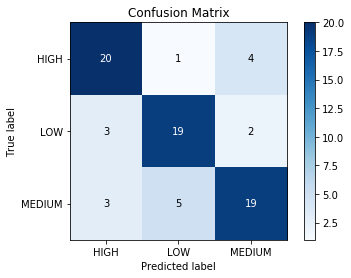

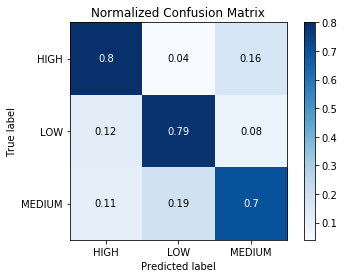

In [13]:
predictions_validate = cross_val_predict(learner, X_validate, y_validate.values.ravel(), cv=10)

# Metrics
print('Accuracy: ' + str(accuracy_score(y_validate, predictions_validate)))
print('F Score (each label): ' + str(fbeta_score(y_validate, predictions_validate, beta = 0.5, average=None)))
print('F Score: ' + str(fbeta_score(y_validate, predictions_validate, beta = 0.5, average='micro')))

# Confusion matrix
skplt.metrics.plot_confusion_matrix(y_validate, predictions_validate, normalize=False)
skplt.metrics.plot_confusion_matrix(y_validate, predictions_validate, normalize=True)
plt.show()

### Testing the model

Accuracy: 0.8169761273209549
F Score (each label): [0.85149864 0.83710407 0.73770492]
F Score: 0.8169761273209549


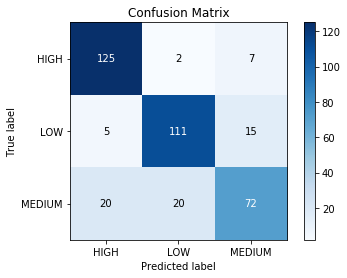

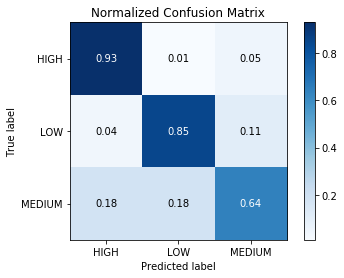

In [14]:
predictions_test = cross_val_predict(learner, X_test, y_test.values.ravel(), cv=10)

# Metrics
print('Accuracy: ' + str(accuracy_score(y_test, predictions_test)))
print('F Score (each label): ' + str(fbeta_score(y_test, predictions_test, beta = 0.5, average=None)))
print('F Score: ' + str(fbeta_score(y_test, predictions_test, beta = 0.5, average='micro')))

# Confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, normalize=False)
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, normalize=True)
plt.show()

## Conclusion

As expected, the larger the balanced subset, the more accurate the cross-validated prediction. The testing subset, that held 50% of the data had the best metrics overall (except for the MEDIUM label).

In the proposed real-world scenario, though, the accuracy can only be assessed by addressing resources to the flagged municipalities (labeled HIGH according to an expectation of maximizing rescues per inspection). It's very promising, nonetheless, to run such experimentations: in the normalized confusion matrix, for instance, we can see that 0.01 (2 occurences) of real HIGH were misclassified as LOW and 0.05 (7 instances) as MEDIUM, while 0.93 (125 municipalities) were correctly classified.

If law enforcement should address the 150 municipalities classified as HIGH, we should expect the same 125 places (~83.33%) to be correctly classified, therefore generating more rescues per inspection. 5 of them (~3.33%) would represent a low rate of success, since the municipalities labeled as LOW are near-zero rescues per inspections, from the distribution used for labeling (from 0 to ~0.045). Similarly, we'd have 20 inspections (~13.33% of the 150 labeled as HIGH) with fewer rescues (from ~0.045 to ~0.139) according to the ratings and the confusion matrix. 

We can also verify the actual feature importance for the accurate predictions, witch may enable us to avoid rhetorical disputes and focus on tackling the problem at hand.

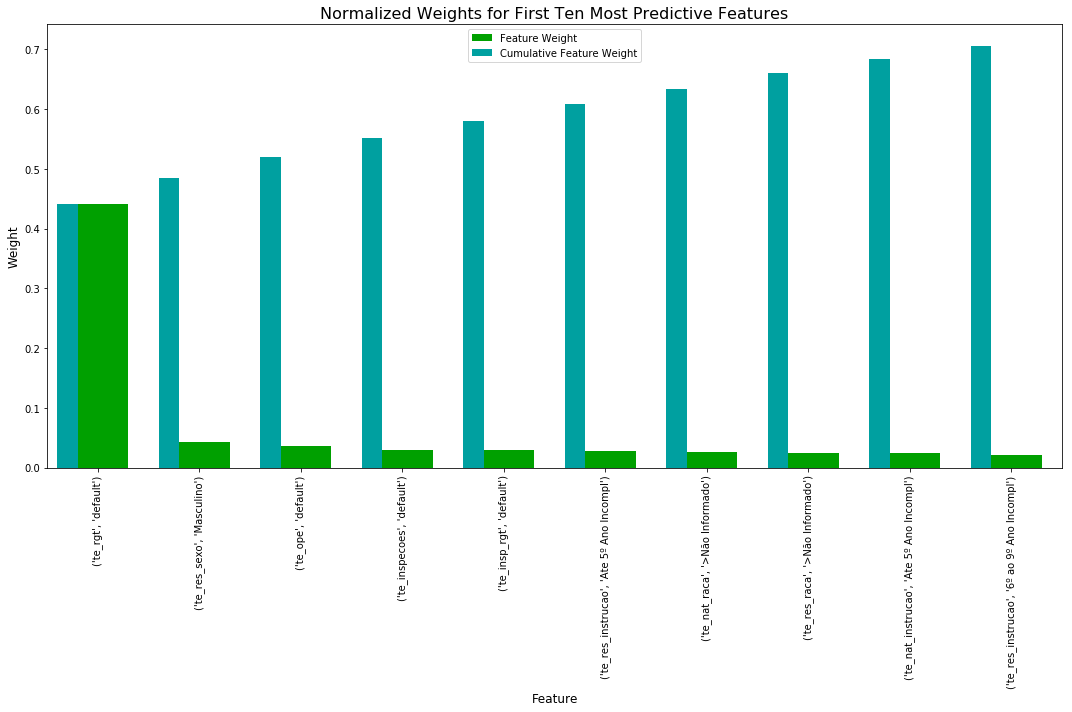

In [15]:
# Display the most important features
import numpy as np

importances = learner.feature_importances_

indices = np.argsort(importances)[::-1]
columns = X_test.columns.values[indices[:10]]
values = importances[indices][:10]

# Create the plot
fig = plt.figure(figsize = (15,10))
plt.title("Normalized Weights for First Ten Most Predictive Features", fontsize = 16)
plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
      label = "Feature Weight")
plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
      label = "Cumulative Feature Weight")
plt.xticks(np.arange(10), columns, rotation='vertical')
plt.xlim((-0.5, 9.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)

plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

Since the dataset used is closely related to inspections and rescues, it tends to a reinforced bias (the number of rescues - te_rgt -, for instance, is obviously extremely relevant to the classification. Some relevant features can bee seen, such as the ammount Male slaves rescued (te_res_sexo - Masculino), the low instruction level (te_res_instrucao and te_nat_instrucao - 5th and 6th to 9th year of formal education). Some issues show up also, such as the race not informed in the reports (te_nat_raca and te_res_raca) being among the most relevant features.

### Future work

Since the results of this study is expected to be included in the Observatório Digital do Trabalho Escravo, the model will be built using the full inspections dataset. Then, it will be applied for labeling municipalities with no inspection record. In order for that to work, we must revisit the raw datasets from IBGE and the check if the high sparsity persists and, if so, how to address this issue.

Those municipalities, now identified, with a label HIGH will be flagged, as the ones already identified in the inspections records. The final output would be a brazilian map of municipalities colored by rating level, revealing which areas should be subject to a more thorough investigation.